# CLIPDraw
Synthesize drawings to match a text prompt!


![](https://kvfrans.com/content/images/2021/06/Screen-Shot-2021-06-10-at-8.47.23-PM.png)


> This work presents CLIPDraw, an algorithm that synthesizes novel drawings based on natural language input. CLIPDraw does not require any training; rather a pre-trained CLIP language-image encoder is used as a metric for maximizing similarity between the given description and a generated drawing. Crucially, CLIPDraw operates over vector strokes rather than pixel images, a constraint that biases drawings towards simpler human-recognizable shapes. Results compare between CLIPDraw and other synthesis-through-optimization methods, as well as highlight various interesting behaviors of CLIPDraw, such as satisfying ambiguous text in multiple ways, reliably producing drawings in diverse artistic styles, and scaling from simple to complex visual representations as stroke count is increased. 





This Colab notebook goes along with the paper: [CLIPDraw: Exploring Text-to-Drawing Synthesis through Language-Image Encoders](https://arxiv.org/abs/2106.14843) 

by **Kevin Frans**, L.B. Soros, Olaf Witkowski

Read the blog post for cool results and analysis! [https://kvfrans.com/clipdraw-exploring-text-to-drawing-synthesis/](https://kvfrans.com/clipdraw-exploring-text-to-drawing-synthesis/)

Feel free to tweet me any cool creations, [@kvfrans](https://twitter.com/kvfrans)

Code adapted from diffvg: https://github.com/BachiLi/diffvg/blob/master/apps/painterly_rendering.py

--- 






**STEPS:**


1. Click "Connect" in the top right corner
2. Runtime -> Change runtime type -> Hardware accelerator -> GPU
2. Click the run button on "Pre Installation". This will install dependencies, it may take a while.
2. **Important:** Runtime -> Restart Runtime
3. Run the "Imports and Notebook Utilities" and "Load CLIP" sections.


5. "Curve Optimizer" will synthesize a drawing to match your text. You can edit the text prompt at the top of the code block.
6. "Video Renderer" can create videos that show the optimization process, and videos that render a drawing stroke-by-stroke.

In [1]:
#@title Pre Installation {vertical-output: true}

import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

# !pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
%cd /content/
!pip install svgwrite
!pip install svgpathtools
!pip install cssutils
!pip install numba
!pip install torch-tools
!pip install visdom

!git clone https://github.com/BachiLi/diffvg
%cd diffvg
# !ls
!git submodule update --init --recursive

data = []
with open("/content/diffvg/CMakeLists.txt", "r+") as inFile:
    for line in inFile:
        if "find_package(TensorFlow)" in line:
            pass
        else:
            data.append(line)
    inFile.seek(0)
    for d in data:
        inFile.write(d)
    inFile.truncate()
!python setup.py install

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git --no-deps

CUDA version: 11.8
/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 1.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 KB 2.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 KB 8.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 27.2 MB/s eta 0:00:

In [2]:
#@title Imports and Notebook Utilities {vertical-output: true}
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img = img.resize((max_size, max_size))
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))


def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

from torchvision import utils
def show_img(img):
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    img = np.uint8(img * 254)
    # img = np.repeat(img, 4, axis=0)
    # img = np.repeat(img, 4, axis=1)
    pimg = PIL.Image.fromarray(img, mode="RGB")
    imshow(pimg)

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

!nvidia-smi -L

import numpy as np
import torch
import os

# torch.set_default_tensor_type('torch.cuda.FloatTensor')

print("Torch version:", torch.__version__)

# !pip install DALL-E

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
GPU 0: Tesla T4 (UUID: GPU-95ce0df4-2752-5726-3ad3-31a505483425)
Torch version: 1.13.1+cu116


In [3]:
#@title Load CLIP {vertical-output: true}

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import os
import clip
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100

# Load the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load('ViT-B/32', device, jit=False)

nouns = "aardvark abyssinian accelerator accordion account accountant acknowledgment acoustic acrylic act action active activity actor actress adapter addition address adjustment adult advantage advertisement advice afghanistan africa aftermath afternoon aftershave afterthought age agenda agreement air airbus airmail airplane airport airship alarm albatross alcohol algebra algeria alibi alley alligator alloy almanac alphabet alto aluminium aluminum ambulance america amount amusement anatomy anethesiologist anger angle angora animal anime ankle answer ant antarctica anteater antelope anthony anthropology apartment apology apparatus apparel appeal appendix apple appliance approval april aquarius arch archaeology archeology archer architecture area argentina argument aries arithmetic arm armadillo armchair armenian army arrow art ash ashtray asia asparagus asphalt asterisk astronomy athlete atm atom attack attempt attention attic attraction august aunt australia australian author authorisation authority authorization avenue babies baboon baby back backbone bacon badge badger bag bagel bagpipe bail bait baker bakery balance balinese ball balloon bamboo banana band bandana bangladesh bangle banjo bank bankbook banker bar barbara barber barge baritone barometer base baseball basement basin basket basketball bass bassoon bat bath bathroom bathtub battery battle bay beach bead beam bean bear beard beast beat beautician beauty beaver bed bedroom bee beech beef beer beet beetle beggar beginner begonia behavior belgian belief believe bell belt bench bengal beret berry bestseller betty bibliography bicycle bike bill billboard biology biplane birch bird birth birthday bit bite black bladder blade blanket blinker blizzard block blood blouse blow blowgun blue board boat bobcat body bolt bomb bomber bone bongo bonsai book bookcase booklet boot border botany bottle bottom boundary bow bowl bowling box boy bra brace bracket brain brake branch brand brandy brass brazil bread break breakfast breath brian brick bridge british broccoli brochure broker bronze brother brother-in-law brow brown brush bubble bucket budget buffer buffet bugle building bulb bull bulldozer bumper bun burglar burma burn burst bus bush business butane butcher butter button buzzard cabbage cabinet cable cactus cafe cake calculator calculus calendar calf call camel camera camp can canada canadian cancer candle cannon canoe canvas cap capital cappelletti capricorn captain caption car caravan carbon card cardboard cardigan care carnation carol carp carpenter carriage carrot cart cartoon case cast castanet cat catamaran caterpillar cathedral catsup cattle cauliflower cause caution cave c-clamp cd ceiling celery celeste cell cellar cello celsius cement cemetery cent centimeter century ceramic cereal certification chain chair chalk chance change channel character chard charles chauffeur check cheek cheese cheetah chef chemistry cheque cherries cherry chess chest chick chicken chicory chief child children chill chime chimpanzee chin china chinese chive chocolate chord christmas christopher chronometer church cicada cinema circle circulation cirrus citizenship city clam clarinet class claus clave clef clerk click client climb clipper cloakroom clock close closet cloth cloud cloudy clover club clutch coach coal coast coat cobweb cockroach cocktail cocoa cod coffee coil coin coke cold collar college collision colombia colon colony color colt column columnist comb comfort comic comma command commission committee community company comparison competition competitor composer composition computer condition condor cone confirmation conga congo conifer connection consonant continent control cook cooking copper copy copyright cord cork cormorant corn cornet correspondent cost cotton couch cougar cough country course court cousin cover cow cowbell crab crack cracker craftsman crate crawdad crayfish crayon cream creator creature credit creditor creek crib cricket crime criminal crocodile crocus croissant crook crop cross crow crowd crown crush cry cub cuban cucumber cultivator cup cupboard cupcake curler currency current curtain curve cushion custard customer cut cuticle cycle cyclone cylinder cymbal dad daffodil dahlia daisy damage dance dancer danger daniel dash dashboard database date daughter david day dead deadline deal death deborah debt debtor decade december decimal decision decrease dedication deer defense deficit degree delete delivery den denim dentist deodorant department deposit description desert design desire desk dessert destruction detail detective development dew diamond diaphragm dibble dictionary dietician difference digestion digger digital dill dime dimple dinghy dinner dinosaur diploma dipstick direction dirt disadvantage discovery discussion disease disgust dish distance distribution distributor diving division divorced dock doctor dog dogsled doll dollar dolphin domain donald donkey donna door dorothy double doubt downtown dragon dragonfly drain drake drama draw drawbridge drawer dream dredger dress dresser dressing drill drink drive driver driving drizzle drop drug drum dry dryer duck duckling dugout dungeon dust eagle ear earth earthquake ease east edge edger editor editorial education edward eel effect egg eggnog eggplant egypt eight elbow element elephant elizabeth ellipse emery employee employer encyclopedia end enemy energy engine engineer engineering english enquiry entrance environment epoch epoxy equinox equipment era error estimate ethernet ethiopia euphonium europe evening event examination example exchange exclamation exhaust ex-husband existence expansion experience expert explanation ex-wife eye eyebrow eyelash eyeliner face facilities fact factory fahrenheit fairies fall family fan fang farm farmer fat father father-in-law faucet fear feast feather feature february fedelini feedback feeling feet felony female fender ferry ferryboat fertilizer fiber fiberglass fibre fiction field fifth fight fighter file find fine finger fir fire fired fireman fireplace firewall fish fisherman flag flame flare flat flavor flax flesh flight flock flood floor flower flugelhorn flute fly foam fog fold font food foot football footnote force forecast forehead forest forgery fork form format fortnight foundation fountain fowl fox foxglove fragrance frame france freckle freeze freezer freighter french freon friction friday fridge friend frog front frost frown fruit fuel fur furniture galley gallon game gander garage garden garlic gas gasoline gate gateway gauge gazelle gear gearshift geese gemini gender geography geology geometry george geranium german germany ghana ghost giant giraffe girdle girl gladiolus glass glider gliding glockenspiel glove glue goal goat gold goldfish golf gondola gong good-bye goose gore-tex gorilla gosling government governor grade grain gram granddaughter grandfather grandmother grandson grape graphic grass grasshopper gray grease great-grandfather great-grandmother greece greek green grenade grey grill grip ground group grouse growth guarantee guatemalan guide guilty guitar gum gun gym gymnast hacksaw hail hair haircut half-brother half-sister halibut hall hallway hamburger hammer hamster hand handball handicap handle handsaw harbor hardboard hardcover hardhat hardware harmonica harmony harp hat hate hawk head headlight headline health hearing heart heat heaven hedge height helen helicopter helium hell helmet help hemp hen heron herring hexagon hill himalayan hip hippopotamus history hobbies hockey hoe hole holiday home honey hood hook hope horn horse hose hospital hot hour hourglass house hovercraft hub hubcap humidity humor hurricane hyacinth hydrant hydrofoil hydrogen hyena hygienic ice icebreaker icicle icon idea ikebana illegal imprisonment improvement impulse inch income increase index india indonesia industry ink innocent input insect instruction instrument insulation insurance interactive interest internet interviewer intestine invention inventory invoice iran iraq iris iron island israel italian italy jacket jaguar jail jam james january japan japanese jar jasmine jason jaw jeans jeep jeff jelly jellyfish jennifer jet jewel jogging john join joke joseph journey judge judo juice july jumbo jump jumper june jury justice jute kale kamikaze kangaroo karate karen kayak kendo kenneth kenya ketchup kettle kettledrum kevin key keyboard keyboarding kick kidney kilogram kilometer kimberly kiss kitchen kite kitten kitty knee knickers knife knight knot knowledge kohlrabi korean laborer lace ladybug lake lamb lamp lan land landmine language larch lasagna latency latex lathe laugh laundry laura law lawyer layer lead leaf learning leather leek leg legal lemonade lentil leo leopard letter lettuce level libra library license lier lift light lightning lilac lily limit linda line linen link lion lip lipstick liquid liquor lisa list literature litter liver lizard llama loaf loan lobster lock locket locust look loss lotion love low lumber lunch lunchroom lung lunge lute luttuce lycra lynx lyocell lyre lyric macaroni machine macrame magazine magic magician maid mail mailbox mailman makeup malaysia male mall mallet man manager mandolin manicure manx map maple maraca marble march margaret margin maria marimba mark mark market married mary mascara mask mass match math mattock may mayonnaise meal measure meat mechanic medicine meeting melody memory men menu mercury message metal meteorology meter methane mexican mexico mice michael michelle microwave middle mile milk milkshake millennium millimeter millisecond mimosa mind mine minibus mini-skirt minister mint minute mirror missile mist mistake mitten moat modem mole mom monday money monkey month moon morning morocco mosque mosquito mother mother-in-law motion motorboat motorcycle mountain mouse moustache mouth move multi-hop multimedia muscle museum music musician mustard myanmar nail name nancy napkin narcissus nation neck need needle neon nepal nephew nerve nest net network news newsprint newsstand nic nickel niece nigeria night nitrogen node noise noodle north north america north korea norwegian nose note notebook notify novel november number numeric nurse nut nylon oak oatmeal objective oboe observation occupation ocean ocelot octagon octave october octopus odometer offence offer office oil okra olive onion open opera operation ophthalmologist opinion option orange orchestra orchid order organ organisation organization ornament ostrich otter ounce output outrigger oval oven overcoat owl owner ox oxygen oyster package packet page pail pain paint pair pajama pakistan palm pamphlet pan pancake pancreas panda pansy panther panties pantry pants panty pantyhose paper paperback parade parallelogram parcel parent parentheses park parrot parsnip part particle partner partridge party passbook passenger passive pasta paste pastor pastry patch path patient patio patricia paul payment pea peace peak peanut pear pedestrian pediatrician peen peer-to-peer pelican pen penalty pencil pendulum pentagon peony pepper perch perfume period periodical peripheral permission persian person peru pest pet pharmacist pheasant philippines philosophy phone physician piano piccolo pickle picture pie pig pigeon pike pillow pilot pimple pin pine ping pink pint pipe pisces pizza place plain plane planet plant plantation plaster plasterboard plastic plate platinum play playground playroom pleasure plier plot plough plow plywood pocket poet point poison poland police policeman polish politician pollution polo polyester pond popcorn poppy population porch porcupine port porter position possibility postage postbox pot potato poultry pound powder power precipitation preface prepared pressure price priest print printer prison probation process processing produce product production professor profit promotion propane property prose prosecution protest protocol pruner psychiatrist psychology ptarmigan puffin pull puma pump pumpkin punch punishment puppy purchase purple purpose push pvc pyjama pyramid quail quality quart quarter quartz queen question quicksand quiet quill quilt quince quit quiver quotation rabbi rabbit racing radar radiator radio radish raft rail railway rain rainbow raincoat rainstorm rake ramie random range rat rate raven ravioli ray rayon reaction reading reason receipt recess record recorder rectangle red reduction refrigerator refund regret reindeer relation relative religion relish reminder repair replace report representative request resolution respect responsibility rest restaurant result retailer revolve revolver reward rhinoceros rhythm rice richard riddle rifle ring rise risk river riverbed road roadway roast robert robin rock rocket rod roll romania romanian ronald roof room rooster root rose rotate route router rowboat rub rubber rugby rule run russia russian rutabaga ruth sack sagittarius sail sailboat sailor salad salary sale salesman salmon salt sampan samurai sand sandra sandwich santa sarah sardine satin saturday sauce saudi arabia sausage save saw saxophone scale scallion scanner scarecrow scarf scene scent schedule school science scissors scooter scorpio scorpion scraper screen screw screwdriver sea seagull seal seaplane search seashore season seat second secretary secure security seed seeder segment select selection self semicircle semicolon sense sentence separated september servant server session sex shade shadow shake shallot shame shampoo shape share shark sharon shears sheep sheet shelf shell shield shingle ship shirt shock shoe shoemaker shop shorts shoulder shovel show shrimp shrine siamese siberian side sideboard sidecar sidewalk sign signature silica silk silver sing singer single sink sister sister-in-law size skate skiing skill skin skirt sky slash slave sled sleep sleet slice slime slip slipper slope smash smell smile smoke snail snake sneeze snow snowboarding snowflake snowman snowplow snowstorm soap soccer society sociology sock soda sofa softball softdrink software soil soldier son song soprano sort sound soup sousaphone south africa south america south korea soy soybean space spade spaghetti spain spandex spark sparrow spear specialist speedboat sphere sphynx spider spike spinach spleen sponge spoon spot spring sprout spruce spy square squash squid squirrel stage staircase stamp star start starter state statement station statistic steam steel stem step step-aunt step-brother stepdaughter step-daughter step-father step-grandfather step-grandmother stepmother step-mother step-sister stepson step-son step-uncle steven stew stick stinger stitch stock stocking stomach stone stool stop stopsign stopwatch store storm story stove stranger straw stream street streetcar stretch string structure study sturgeon submarine substance subway success sudan suede sugar suggestion suit summer sun sunday sundial sunflower sunshine supermarket supply support surfboard surgeon surname surprise susan sushi swallow swamp swan sweater sweatshirt sweatshop swedish sweets swim swimming swing swiss switch sword swordfish sycamore syria syrup system table tablecloth tabletop tachometer tadpole tail tailor taiwan talk tank tanker tanzania target taste taurus tax taxi taxicab tea teacher teaching team technician teeth television teller temper temperature temple tempo tendency tennis tenor tent territory test text textbook texture thailand theater theory thermometer thing thistle thomas thought thread thrill throat throne thumb thunder thunderstorm thursday ticket tie tiger tights tile timbale time timer timpani tin tip tire titanium title toad toast toe toenail toilet tomato tom-tom ton tongue tooth toothbrush toothpaste top tornado tortellini tortoise touch tower town toy tractor trade traffic trail train tramp transaction transmission transport trapezoid tray treatment tree trial triangle trick trigonometry trip trombone trouble trousers trout trowel truck trumpet trunk t-shirt tsunami tub tuba tuesday tugboat tulip tuna tune turkey turkey turkish turn turnip turnover turret turtle tv twig twilight twine twist typhoon tyvek uganda ukraine ukrainian umbrella uncle underclothes underpants undershirt underwear unit united kingdom unshielded use utensil uzbekistan vacation vacuum valley value van vase vault vegetable vegetarian veil vein velvet venezuela venezuelan verdict vermicelli verse vessel vest veterinarian vibraphone vietnam view vinyl viola violet violin virgo viscose vise vision visitor voice volcano volleyball voyage vulture waiter waitress walk wall wallaby wallet walrus war warm wash washer wasp waste watch watchmaker water waterfall wave wax way wealth weapon weasel weather wedge wednesday weed weeder week weight whale wheel whip whiskey whistle white wholesaler whorl wilderness william willow wind windchime window windscreen windshield wine wing winter wire wish witch withdrawal witness wolf woman women wood wool woolen word work workshop worm wound wrecker wren wrench wrinkle wrist writer xylophone yacht yak yam yard yarn year yellow yew yogurt yoke yugoslavian zebra zephyr zinc zipper zone zoo zoology"
nouns = nouns.split(" ")
noun_prompts = ["a drawing of a " + x for x in nouns]

# Calculate features
with torch.no_grad():
    nouns_features = model.encode_text(torch.cat([clip.tokenize(noun_prompts).to(device)]))
print(nouns_features.shape, nouns_features.dtype)


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 105MiB/s]


torch.Size([2343, 512]) torch.float16


In [ ]:
#preprocess.transforms = preprocess.transforms[:2] + [preprocess.transforms[-1]]
#preprocess

In [4]:
#@title Helper functions
def check_colinear(v, w): # check whether or not two vectors are colinear, useful to force a parallelogram
    return torch.abs((torch.norm(v) * torch.norm(w)) - torch.dot(v,w)) < 1e-12

def vectors_angle_cos(v,w): #computes the cosinus of the angle between vectors v and w
  return torch.dot(v,w)/(torch.norm(v) * torch.norm(w))

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')
def create_polygon_from_center_and_orientation(center, angle, width): #squares will have length 1/10
  factor = 1/20
  rotationMatrix = torch.zeros(2,2)
  rotationMatrix[0][0] = torch.cos(angle)
  rotationMatrix[0][1] = -torch.sin(angle)
  rotationMatrix[1][0] = torch.sin(angle)
  rotationMatrix[1][1] = torch.cos(angle)
  
  p1 = center  + (torch.tensor([-1,-1]) * factor) @ rotationMatrix
  p2 = center + (torch.tensor([1,-1])  * factor) @ rotationMatrix
  p3 = center + (torch.tensor([1,1])  * factor) @ rotationMatrix
  p4 = center + (torch.tensor([-1,1])   * factor) @ rotationMatrix
  #print(p4)
  points = torch.cat([p1, p2, p3, p4], dim = 0) * width
  #points.requires_grad = True
  #print(points.requires_grad)
  return pydiffvg.Polygon(points = points, is_closed = True)

/content/diffvg/apps


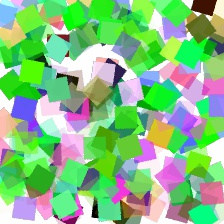

render loss: 141.5
iteration: 10

Top predictions:

            lamb: 4.51%
           sheep: 3.41%
           llama: 3.10%
             cow: 2.96%
             pet: 1.77%
           horse: 1.59%
          donkey: 1.47%
            calf: 1.44%
            wool: 1.29%
           maple: 1.20%


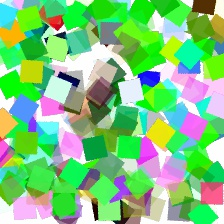

render loss: 141.25
iteration: 20

Top predictions:

           horse: 6.20%
          knight: 1.59%
          donkey: 1.00%
            polo: 0.92%
            colt: 0.85%
      competitor: 0.81%
           hedge: 0.80%
             cow: 0.80%
             pet: 0.70%
           green: 0.67%


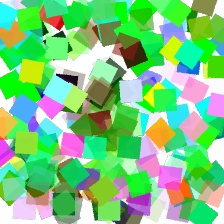

render loss: 140.0
iteration: 30

Top predictions:

           horse: 11.30%
             cow: 3.96%
          donkey: 3.50%
           llama: 2.12%
          cattle: 1.73%
           green: 1.65%
             pet: 1.63%
           spike: 0.97%
           sleet: 0.93%
            colt: 0.84%


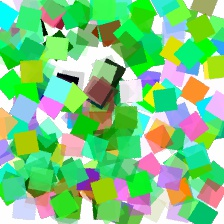

render loss: 139.875
iteration: 40

Top predictions:

             cow: 3.71%
           horse: 1.95%
           sheep: 1.81%
          donkey: 1.65%
           sleet: 1.15%
             dew: 1.15%
           green: 1.13%
           slime: 1.08%
           llama: 0.98%
          cattle: 0.84%


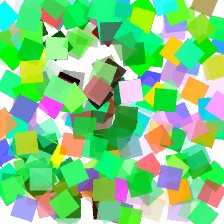

render loss: 139.25
iteration: 50

Top predictions:

           horse: 5.98%
          donkey: 4.73%
             cow: 3.86%
           spike: 3.10%
           green: 3.05%
           llama: 2.87%
            goat: 1.79%
             pet: 1.42%
             pea: 1.27%
             dew: 1.14%


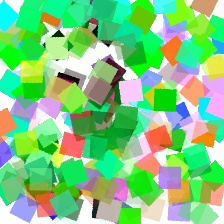

render loss: 139.625
iteration: 60

Top predictions:

          cattle: 7.77%
             cow: 7.77%
           horse: 2.81%
         cowbell: 1.51%
            bull: 1.21%
           sheep: 1.14%
           shake: 0.93%
      processing: 0.90%
          seeder: 0.76%
          donkey: 0.64%


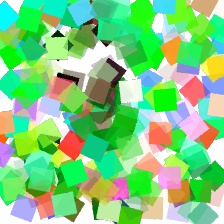

render loss: 139.0
iteration: 70

Top predictions:

          donkey: 3.00%
           horse: 2.87%
           hedge: 2.78%
           llama: 1.69%
           green: 1.31%
             cow: 1.23%
          cattle: 0.86%
           spike: 0.83%
           block: 0.80%
           grass: 0.69%


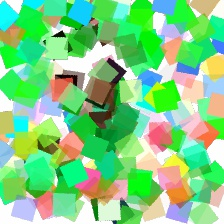

render loss: 139.125
iteration: 80

Top predictions:

           horse: 8.86%
          donkey: 2.38%
             cow: 1.13%
            polo: 1.11%
          cattle: 0.85%
            cone: 0.72%
           green: 0.70%
           hedge: 0.67%
           spade: 0.64%
            farm: 0.62%


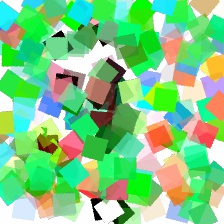

render loss: 138.75
iteration: 90

Top predictions:

           horse: 19.38%
            polo: 2.93%
          donkey: 2.21%
            colt: 1.40%
           spike: 1.30%
        birthday: 1.16%
       milkshake: 1.08%
           shake: 1.04%
           apple: 1.00%
      competitor: 0.97%


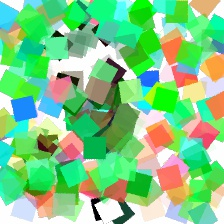

render loss: 138.875
iteration: 100

Top predictions:

           horse: 17.24%
             cow: 1.46%
          donkey: 1.39%
           green: 1.21%
           salad: 1.07%
            polo: 1.02%
            mint: 0.91%
             gum: 0.87%
          cattle: 0.76%
           shake: 0.71%


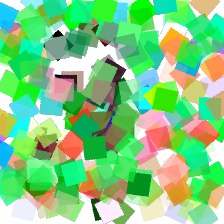

render loss: 138.0
iteration: 110

Top predictions:

           horse: 8.58%
       milkshake: 5.99%
           shake: 2.20%
          sweets: 1.97%
           sugar: 1.94%
             gum: 1.83%
          donkey: 1.56%
         drizzle: 1.42%
         cupcake: 1.42%
           salad: 1.40%


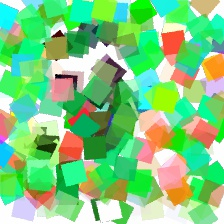

render loss: 138.375
iteration: 120

Top predictions:

           horse: 10.76%
           hedge: 2.94%
           salad: 2.40%
            farm: 1.93%
       milkshake: 1.41%
          parade: 1.25%
           field: 1.13%
            polo: 1.12%
           green: 1.03%
            game: 1.00%


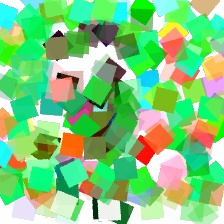

render loss: 137.625
iteration: 130

Top predictions:

       milkshake: 13.12%
           horse: 9.01%
           shake: 3.16%
          donkey: 1.75%
         dessert: 1.43%
           drink: 1.30%
          yogurt: 1.26%
         popcorn: 1.22%
          cereal: 1.20%
            soda: 1.18%


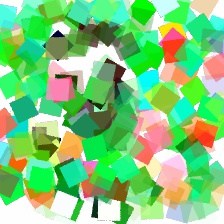

render loss: 137.75
iteration: 140

Top predictions:

           horse: 14.17%
         balloon: 4.26%
       milkshake: 3.31%
           green: 2.79%
        birthday: 2.04%
          helium: 1.95%
         cupcake: 1.52%
          mimosa: 1.49%
          donkey: 1.30%
             gum: 1.15%


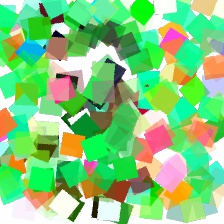

render loss: 138.375
iteration: 150

Top predictions:

           horse: 15.98%
            colt: 1.97%
            polo: 1.94%
           cocoa: 1.51%
       milkshake: 1.46%
           shake: 1.44%
        birthday: 1.35%
          donkey: 1.27%
           green: 0.93%
         cupcake: 0.83%


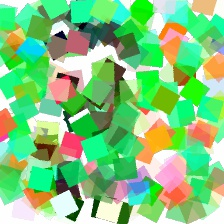

render loss: 138.375
iteration: 160

Top predictions:

           horse: 2.95%
           shake: 1.85%
           green: 1.02%
         cowbell: 0.99%
           salad: 0.89%
             gum: 0.82%
          cereal: 0.72%
         popcorn: 0.68%
           spike: 0.66%
            soda: 0.64%


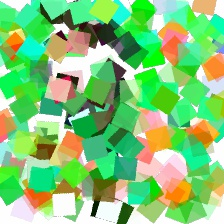

render loss: 137.875
iteration: 170

Top predictions:

           cocoa: 4.31%
       milkshake: 3.57%
          yogurt: 2.10%
             cow: 1.88%
         cupcake: 1.85%
           horse: 1.79%
           salad: 1.63%
            mint: 1.49%
           green: 1.44%
            milk: 1.38%


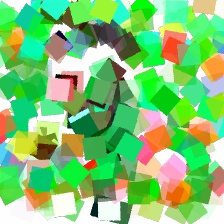

render loss: 137.625
iteration: 180

Top predictions:

       milkshake: 9.33%
           horse: 5.23%
           shake: 2.51%
           salad: 2.29%
            polo: 1.65%
      competitor: 1.55%
         dessert: 1.45%
           drink: 1.30%
          donkey: 1.03%
           green: 0.98%


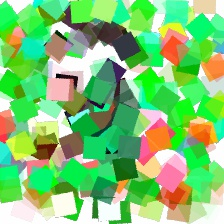

render loss: 137.75
iteration: 190

Top predictions:

           horse: 3.94%
           apple: 2.63%
         drizzle: 1.72%
          donkey: 1.64%
         cupcake: 1.62%
       milkshake: 1.59%
           cocoa: 1.57%
          celery: 1.36%
        birthday: 1.24%
           berry: 1.22%


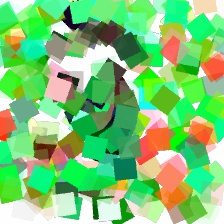

render loss: 137.875
iteration: 200

Top predictions:

           horse: 10.92%
        birthday: 4.70%
       milkshake: 3.72%
         cupcake: 2.08%
          sweets: 1.99%
           green: 1.90%
           sugar: 1.45%
          donkey: 1.45%
            cake: 1.41%
         popcorn: 1.35%


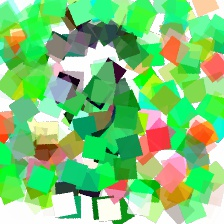

render loss: 137.5
iteration: 210

Top predictions:

          celery: 6.84%
       milkshake: 2.99%
           horse: 2.90%
           green: 2.37%
           apple: 1.90%
          sprout: 1.81%
             pea: 1.70%
            soda: 1.65%
            corn: 1.60%
          yogurt: 1.57%


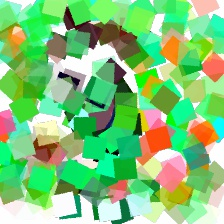

render loss: 137.375
iteration: 220

Top predictions:

           horse: 7.29%
         cupcake: 4.28%
          donkey: 3.67%
          sprout: 2.64%
             cow: 2.40%
           green: 1.60%
           cocoa: 1.48%
          sweets: 1.41%
            cake: 1.33%
        birthday: 1.19%


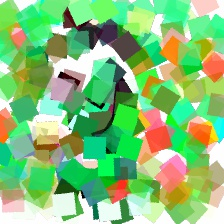

render loss: 137.25
iteration: 230

Top predictions:

           horse: 5.54%
       milkshake: 2.83%
           shake: 2.42%
           green: 1.80%
         popcorn: 1.69%
            pail: 1.51%
           salad: 1.49%
          celery: 1.49%
          donkey: 1.34%
           cocoa: 1.30%


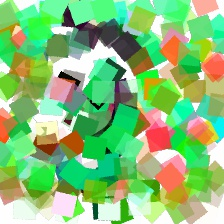

render loss: 137.625
iteration: 240

Top predictions:

           horse: 11.85%
        birthday: 8.67%
          helium: 3.04%
         balloon: 3.00%
         drizzle: 2.64%
           green: 2.41%
         cupcake: 1.90%
           spike: 1.79%
            polo: 0.99%
             pet: 0.93%


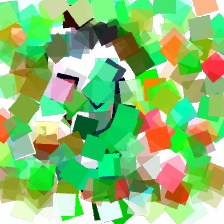

render loss: 137.25
iteration: 250

Top predictions:

       milkshake: 14.47%
           horse: 8.91%
         cupcake: 3.54%
           shake: 3.54%
         drizzle: 1.99%
          sweets: 1.96%
           sugar: 1.70%
         dessert: 1.52%
           cocoa: 1.45%
            soda: 1.45%


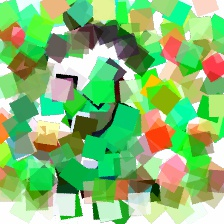

render loss: 137.0
iteration: 260

Top predictions:

         cupcake: 21.79%
           horse: 9.38%
            cake: 5.26%
         dessert: 3.34%
        birthday: 3.19%
          donkey: 1.82%
           salad: 1.73%
          sweets: 1.60%
       milkshake: 1.51%
           green: 1.39%


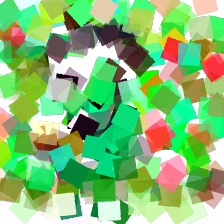

render loss: 136.875
iteration: 270

Top predictions:

         cupcake: 12.41%
           horse: 6.64%
       milkshake: 4.35%
            cake: 3.39%
        birthday: 3.14%
           cocoa: 2.44%
           shake: 1.82%
          donkey: 1.55%
         custard: 1.35%
          sweets: 1.29%


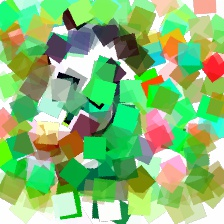

render loss: 137.125
iteration: 280

Top predictions:

           horse: 14.36%
         cupcake: 8.71%
        birthday: 3.25%
            cake: 2.24%
           salad: 2.20%
         ravioli: 2.17%
           apple: 1.51%
          donkey: 1.32%
          sweets: 1.20%
         dessert: 1.07%


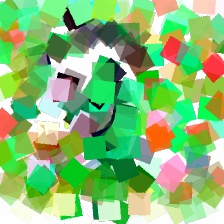

render loss: 137.375
iteration: 290

Top predictions:

           horse: 9.59%
         cupcake: 4.32%
         ravioli: 3.26%
           green: 2.93%
       milkshake: 2.58%
            mint: 1.40%
         drizzle: 1.32%
           salad: 1.22%
            corn: 1.20%
         popcorn: 1.20%


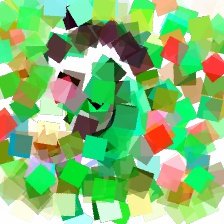

render loss: 137.5
iteration: 300

Top predictions:

         cupcake: 24.26%
           horse: 3.33%
         dessert: 3.23%
          sweets: 2.64%
       milkshake: 2.56%
            cake: 2.40%
          yogurt: 1.96%
             cow: 1.73%
         custard: 1.68%
           cocoa: 1.48%


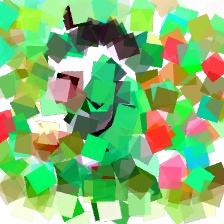

render loss: 136.75
iteration: 310

Top predictions:

           horse: 13.82%
            corn: 1.93%
       milkshake: 1.87%
           green: 1.73%
         cupcake: 1.63%
          donkey: 1.57%
         ravioli: 1.55%
          yogurt: 1.55%
          knight: 1.48%
           apple: 1.23%


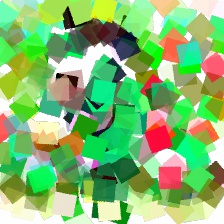

render loss: 137.25
iteration: 320

Top predictions:

           horse: 8.31%
         ravioli: 2.38%
         cowbell: 1.80%
           green: 1.74%
        carriage: 1.26%
          donkey: 1.22%
           field: 1.20%
             run: 1.14%
            mint: 0.89%
          parade: 0.82%


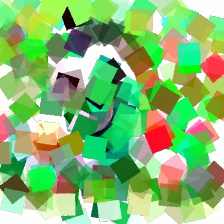

render loss: 137.375
iteration: 330

Top predictions:

           horse: 10.65%
         cupcake: 8.69%
       milkshake: 5.36%
           shake: 3.05%
         popcorn: 1.94%
           green: 1.61%
          yogurt: 1.51%
           salad: 1.21%
            cake: 1.19%
           spike: 1.14%


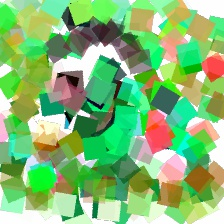

render loss: 136.625
iteration: 340

Top predictions:

         cupcake: 18.27%
           horse: 8.91%
       milkshake: 8.91%
         popcorn: 2.55%
           shake: 1.87%
           spike: 1.50%
           green: 1.50%
          celery: 1.41%
         dessert: 1.24%
          sweets: 1.15%


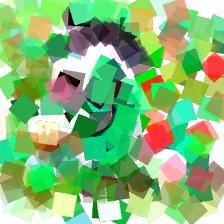

render loss: 137.375
iteration: 350

Top predictions:

           horse: 9.80%
       milkshake: 3.23%
           cocoa: 1.87%
           shake: 1.68%
         cupcake: 1.65%
           apple: 1.50%
         ravioli: 1.48%
           spike: 1.37%
            beet: 1.33%
           green: 1.27%


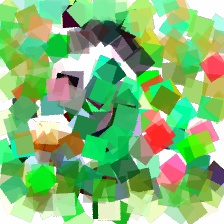

render loss: 137.375
iteration: 360

Top predictions:

         cupcake: 24.24%
        birthday: 7.06%
            cake: 4.02%
       milkshake: 3.55%
           spike: 3.08%
          sweets: 2.64%
             pea: 2.09%
         dessert: 1.81%
          sprout: 1.78%
           slime: 1.73%


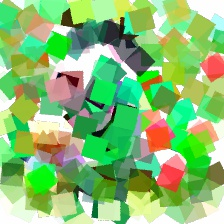

render loss: 137.375
iteration: 370

Top predictions:

           horse: 8.01%
         ravioli: 3.24%
       milkshake: 3.14%
         cupcake: 2.73%
           salad: 2.41%
         popcorn: 2.12%
           shake: 1.90%
          sweets: 1.82%
          celery: 1.68%
            polo: 1.68%


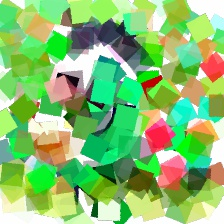

render loss: 137.375
iteration: 380

Top predictions:

         cupcake: 28.05%
            cake: 7.92%
           horse: 5.88%
         dessert: 3.20%
        birthday: 2.06%
         ravioli: 2.00%
            polo: 1.71%
          sweets: 1.33%
            food: 1.01%
         custard: 0.99%


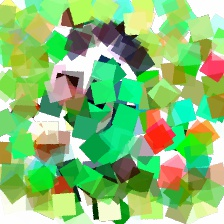

render loss: 137.0
iteration: 390

Top predictions:

         cupcake: 17.14%
           horse: 10.72%
           apple: 4.01%
          donkey: 3.27%
       milkshake: 1.83%
           green: 1.45%
            cake: 1.38%
           spike: 1.34%
         ravioli: 1.34%
            beet: 1.26%


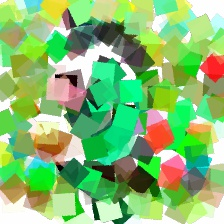

render loss: 136.875
iteration: 400

Top predictions:

           horse: 10.64%
         ravioli: 8.15%
         cupcake: 7.43%
         custard: 2.00%
            cake: 1.61%
          butter: 1.61%
       hamburger: 1.51%
           salad: 1.51%
         dessert: 1.42%
         pancake: 1.40%


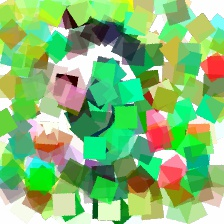

render loss: 136.75
iteration: 410

Top predictions:

           horse: 9.56%
        birthday: 8.44%
         cupcake: 7.93%
            cake: 2.74%
           green: 1.80%
         ravioli: 1.49%
       milkshake: 1.34%
           spike: 1.25%
           salad: 1.04%
          donkey: 0.93%


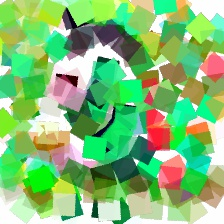

render loss: 136.625
iteration: 420

Top predictions:

         cupcake: 14.05%
           horse: 8.52%
       milkshake: 2.94%
          celery: 2.72%
         dessert: 2.48%
           sugar: 2.22%
           salad: 2.19%
         ravioli: 1.99%
          sweets: 1.76%
            cake: 1.73%


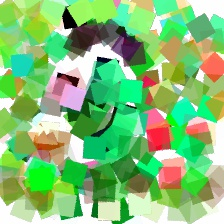

render loss: 136.625
iteration: 430

Top predictions:

         cupcake: 29.39%
           horse: 12.63%
       milkshake: 2.53%
            cake: 2.20%
           spike: 1.79%
           green: 1.44%
         dessert: 1.40%
        birthday: 1.23%
           salad: 1.16%
          sweets: 1.14%


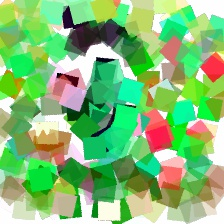

render loss: 136.625
iteration: 440

Top predictions:

         cupcake: 21.41%
           horse: 4.49%
       milkshake: 4.15%
         dessert: 3.04%
           green: 2.26%
           salad: 2.05%
           apple: 1.81%
          sweets: 1.60%
            cake: 1.39%
         custard: 1.23%


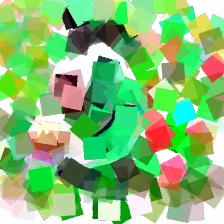

render loss: 136.5
iteration: 450

Top predictions:

         cupcake: 13.78%
           horse: 5.93%
          celery: 2.21%
       milkshake: 1.99%
            cake: 1.99%
           salad: 1.78%
           green: 1.47%
          sweets: 1.41%
            beet: 1.39%
         ravioli: 1.39%


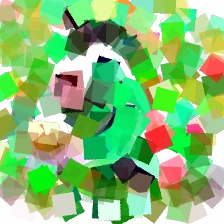

render loss: 137.75
iteration: 460

Top predictions:

         cupcake: 36.18%
           horse: 9.15%
       milkshake: 3.87%
            cake: 2.66%
         dessert: 2.62%
          sweets: 1.89%
           salad: 1.83%
        birthday: 1.38%
           sugar: 1.22%
           green: 1.09%


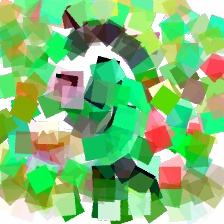

render loss: 137.0
iteration: 470

Top predictions:

         cupcake: 28.83%
            cake: 9.36%
         dessert: 5.86%
          sweets: 3.04%
           slime: 1.60%
            food: 1.51%
           sushi: 1.48%
           sugar: 1.44%
        birthday: 1.19%
           salad: 0.93%


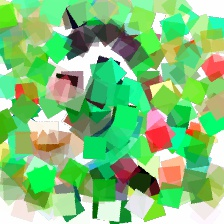

render loss: 136.625
iteration: 480

Top predictions:

         cupcake: 55.62%
         dessert: 3.50%
            cake: 3.09%
          sweets: 2.48%
           salad: 1.07%
            food: 0.82%
         ravioli: 0.82%
           slime: 0.76%
          celery: 0.71%
           spike: 0.69%


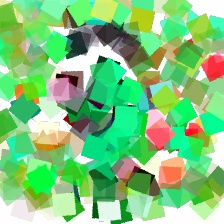

render loss: 136.375
iteration: 490

Top predictions:

         cupcake: 35.23%
           horse: 12.76%
            cake: 2.47%
        birthday: 1.87%
          sweets: 1.78%
           green: 1.48%
          donkey: 1.32%
       milkshake: 1.22%
         ravioli: 1.11%
           salad: 1.00%


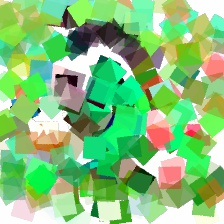

render loss: 136.875
iteration: 500

Top predictions:

         cupcake: 6.25%
         ravioli: 2.57%
             pie: 2.16%
          sprout: 2.06%
       breakfast: 1.79%
         dessert: 1.71%
            cake: 1.53%
           sushi: 1.46%
             pea: 1.46%
           apple: 1.42%


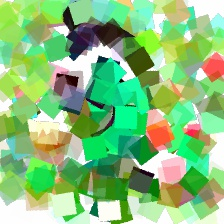

render loss: 137.0
iteration: 510

Top predictions:

         cupcake: 17.42%
           horse: 7.15%
         dessert: 6.02%
        birthday: 5.57%
            cake: 4.47%
         ravioli: 2.39%
       milkshake: 2.39%
             pie: 1.64%
          sweets: 1.17%
         custard: 1.15%


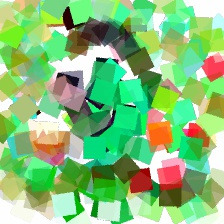

render loss: 136.75
iteration: 520

Top predictions:

         cupcake: 17.47%
           horse: 7.17%
         dessert: 4.85%
            cake: 3.49%
       milkshake: 2.09%
        birthday: 1.76%
         ravioli: 1.63%
           salad: 1.63%
           green: 1.39%
          donkey: 1.37%


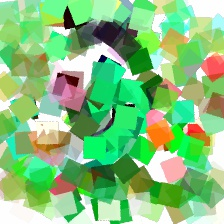

render loss: 136.5
iteration: 530

Top predictions:

           horse: 6.77%
         cupcake: 6.07%
           green: 2.20%
           salad: 2.20%
          sweets: 2.10%
          sprout: 1.97%
           apple: 1.88%
         dessert: 1.82%
           spike: 1.49%
          celery: 1.46%


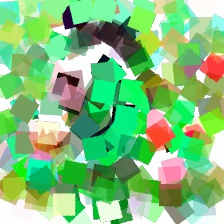

render loss: 137.0
iteration: 540

Top predictions:

         cupcake: 27.51%
           horse: 6.34%
           spike: 2.81%
            cake: 2.37%
             pie: 2.26%
          pickle: 1.84%
         ravioli: 1.81%
           green: 1.17%
         dessert: 1.08%
             dew: 1.08%


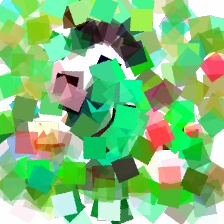

render loss: 136.75
iteration: 550

Top predictions:

         cupcake: 45.83%
         dessert: 6.11%
            cake: 4.47%
          sweets: 3.48%
        birthday: 2.28%
           salad: 1.50%
          sprout: 1.18%
          celery: 1.04%
            food: 0.91%
       milkshake: 0.80%


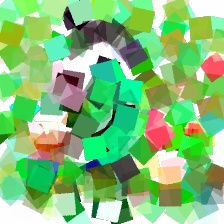

render loss: 136.375
iteration: 560

Top predictions:

         cupcake: 62.55%
           horse: 4.19%
            cake: 2.35%
         dessert: 1.52%
       milkshake: 1.06%
        birthday: 0.85%
           green: 0.72%
          sweets: 0.69%
         custard: 0.69%
           spike: 0.65%


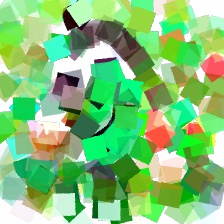

render loss: 136.875
iteration: 570

Top predictions:

         cupcake: 40.50%
           horse: 2.32%
         dessert: 1.67%
          sprout: 1.64%
           apple: 1.55%
            cake: 1.41%
          celery: 1.32%
           sheep: 0.98%
       milkshake: 0.98%
          donkey: 0.97%


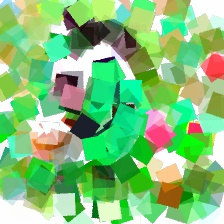

render loss: 137.125
iteration: 580

Top predictions:

         cupcake: 24.33%
       milkshake: 13.23%
           horse: 8.15%
           shake: 3.09%
            cake: 2.77%
          donkey: 1.94%
        birthday: 1.71%
         dessert: 1.66%
           spike: 1.19%
          sweets: 1.10%


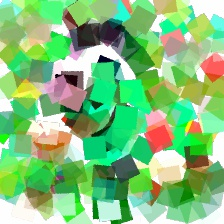

render loss: 137.0
iteration: 590

Top predictions:

         cupcake: 10.96%
           horse: 8.67%
         dessert: 7.89%
            cake: 4.86%
       milkshake: 2.73%
           apple: 2.48%
           salad: 2.48%
          sweets: 1.79%
          yogurt: 1.33%
        birthday: 1.25%


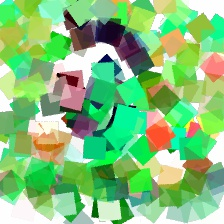

render loss: 136.75
iteration: 600

Top predictions:

           horse: 15.58%
         cupcake: 7.71%
         dessert: 3.64%
            cake: 2.97%
         ravioli: 2.35%
           salad: 2.11%
       milkshake: 2.11%
          sweets: 1.69%
         popcorn: 1.67%
         custard: 1.52%


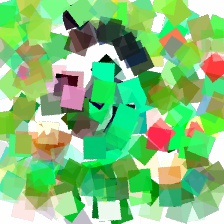

render loss: 136.75
iteration: 610

Top predictions:

         cupcake: 14.89%
       milkshake: 12.54%
         dessert: 3.27%
           horse: 2.59%
           spike: 2.11%
           shake: 1.72%
           cocoa: 1.45%
          sweets: 1.38%
          sprout: 1.22%
          yogurt: 1.17%


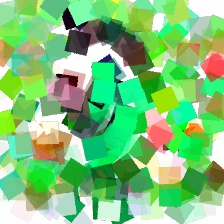

render loss: 137.125
iteration: 620

Top predictions:

           horse: 7.87%
           cocoa: 1.70%
         ravioli: 1.68%
          donkey: 1.65%
           green: 1.55%
       milkshake: 1.53%
            mint: 1.28%
            corn: 1.28%
            colt: 1.26%
          celery: 1.13%


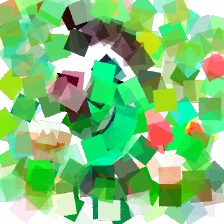

render loss: 137.0
iteration: 630

Top predictions:

         cupcake: 53.17%
            cake: 4.94%
        birthday: 2.41%
          donkey: 2.06%
           spike: 1.71%
          sprout: 1.48%
           horse: 1.44%
         ravioli: 1.16%
         dessert: 1.12%
             pea: 0.99%


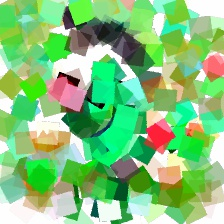

render loss: 136.375
iteration: 640

Top predictions:

           horse: 10.17%
         cupcake: 8.05%
           salad: 3.63%
         ravioli: 2.87%
       milkshake: 2.49%
          celery: 2.20%
         dessert: 2.04%
           apple: 2.00%
           green: 2.00%
         lettuce: 1.47%


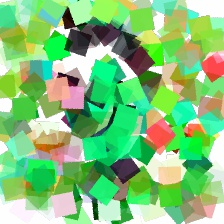

render loss: 137.0
iteration: 650

Top predictions:

         cupcake: 24.88%
           horse: 10.05%
       milkshake: 4.00%
            cake: 2.79%
          sweets: 1.77%
        birthday: 1.72%
         dessert: 1.67%
            polo: 1.52%
           shake: 1.45%
         drizzle: 1.30%


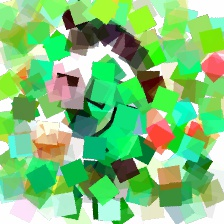

render loss: 137.125
iteration: 660

Top predictions:

         cupcake: 30.88%
           horse: 3.86%
            cake: 3.57%
       milkshake: 2.53%
         dessert: 2.20%
         ravioli: 1.61%
          donkey: 1.44%
        birthday: 1.02%
           shake: 1.01%
             cow: 0.96%


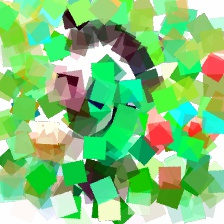

render loss: 136.625
iteration: 670

Top predictions:

           horse: 5.43%
             cow: 3.91%
           salad: 3.85%
         cupcake: 2.30%
      vegetarian: 2.00%
         lettuce: 1.76%
          cattle: 1.63%
          donkey: 1.61%
           green: 1.58%
       milkshake: 1.56%


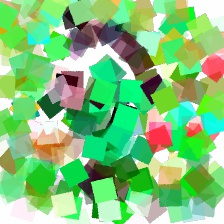

render loss: 136.5
iteration: 680

Top predictions:

         cupcake: 37.65%
            cake: 6.75%
         dessert: 5.77%
           horse: 1.65%
            food: 1.46%
           salad: 1.46%
          sweets: 1.46%
         ravioli: 1.12%
       milkshake: 0.89%
           green: 0.86%


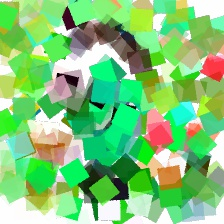

render loss: 137.125
iteration: 690

Top predictions:

         cupcake: 18.44%
           horse: 6.68%
            cake: 3.58%
       milkshake: 3.06%
          donkey: 2.83%
        birthday: 2.35%
         dessert: 1.91%
          sweets: 1.83%
         drizzle: 1.61%
          celery: 1.54%


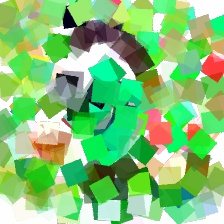

render loss: 136.875
iteration: 700

Top predictions:

         cupcake: 19.27%
           horse: 10.16%
            cake: 2.27%
          donkey: 1.85%
         ravioli: 1.66%
           green: 1.53%
         custard: 1.42%
           spike: 1.35%
        birthday: 1.33%
         dessert: 0.92%


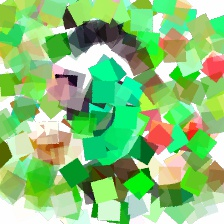

render loss: 136.875
iteration: 710

Top predictions:

         cupcake: 41.80%
           horse: 7.61%
       milkshake: 3.83%
            cake: 2.32%
         dessert: 1.84%
         ravioli: 1.72%
           salad: 1.26%
         popcorn: 1.22%
           green: 1.05%
           shake: 0.98%


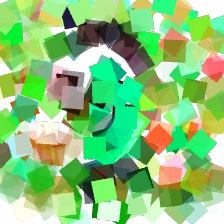

render loss: 136.25
iteration: 720

Top predictions:

         cupcake: 65.19%
           horse: 6.56%
        birthday: 1.40%
            cake: 1.31%
           green: 0.94%
          sweets: 0.82%
       milkshake: 0.77%
         dessert: 0.76%
         ravioli: 0.61%
           salad: 0.54%


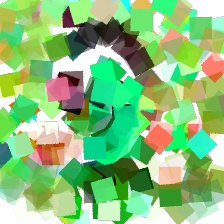

render loss: 136.5
iteration: 730

Top predictions:

         cupcake: 53.66%
         dessert: 1.84%
           horse: 1.75%
            cake: 1.70%
       milkshake: 1.32%
           spike: 1.08%
           salad: 1.08%
          sweets: 1.03%
             cow: 0.85%
          donkey: 0.73%


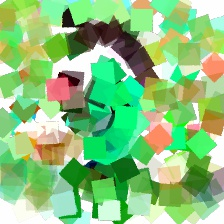

render loss: 136.5
iteration: 740

Top predictions:

         cupcake: 34.25%
           horse: 6.05%
           green: 1.99%
       milkshake: 1.99%
            cake: 1.82%
         dessert: 1.79%
           spike: 1.46%
             dew: 1.31%
          sweets: 1.17%
         ravioli: 1.12%


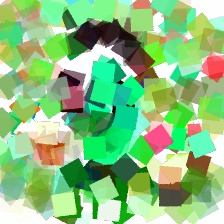

render loss: 136.375
iteration: 750

Top predictions:

           horse: 9.66%
         cupcake: 7.41%
       milkshake: 2.40%
         ravioli: 2.12%
           green: 1.84%
           spike: 1.58%
         dessert: 1.50%
          celery: 1.50%
            polo: 1.48%
          donkey: 1.21%


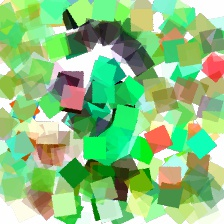

render loss: 136.75
iteration: 760

Top predictions:

         cupcake: 23.51%
       milkshake: 9.21%
           shake: 4.49%
            cake: 3.90%
           horse: 3.78%
        birthday: 2.68%
         dessert: 1.99%
           green: 1.79%
          donkey: 1.53%
           spike: 1.17%


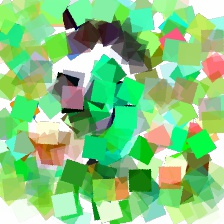

render loss: 136.75
iteration: 770

Top predictions:

         cupcake: 15.83%
        birthday: 13.33%
            cake: 7.14%
       milkshake: 5.14%
           horse: 3.42%
         dessert: 1.83%
           party: 1.43%
           shake: 1.18%
          celery: 1.17%
          sweets: 1.00%


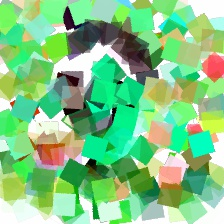

render loss: 136.625
iteration: 780

Top predictions:

         cupcake: 58.74%
            cake: 2.70%
        birthday: 2.04%
           horse: 2.01%
           slime: 1.69%
         dessert: 1.57%
          sprout: 1.26%
           green: 1.24%
           spike: 1.09%
          sweets: 1.09%


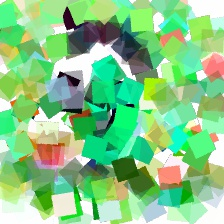

render loss: 136.375
iteration: 790

Top predictions:

         cupcake: 55.91%
            cake: 4.66%
          celery: 1.49%
       milkshake: 1.40%
           spike: 1.01%
             cow: 0.89%
         dessert: 0.89%
           horse: 0.86%
           sugar: 0.85%
          sweets: 0.81%


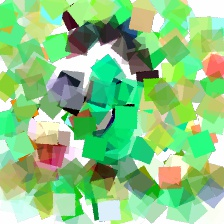

render loss: 137.25
iteration: 800

Top predictions:

         cupcake: 12.14%
           horse: 6.92%
       milkshake: 3.64%
           salad: 2.88%
         dessert: 2.24%
             cow: 1.98%
           apple: 1.86%
            cake: 1.72%
         ravioli: 1.50%
           green: 1.43%


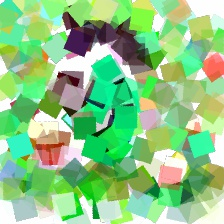

render loss: 136.75
iteration: 810

Top predictions:

       milkshake: 25.44%
           horse: 6.74%
         cupcake: 5.33%
           shake: 5.09%
           green: 1.65%
         dessert: 1.60%
         custard: 1.41%
         popcorn: 1.23%
            polo: 1.00%
          yogurt: 1.00%


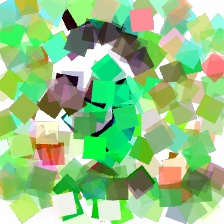

render loss: 136.75
iteration: 820

Top predictions:

           horse: 11.79%
          celery: 6.41%
         cupcake: 6.31%
           green: 2.29%
          donkey: 2.02%
          pickle: 2.02%
            dill: 1.67%
            corn: 1.60%
         custard: 1.57%
           spike: 1.45%


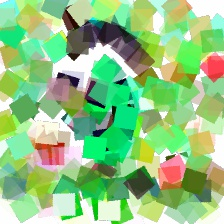

render loss: 136.5
iteration: 830

Top predictions:

         cupcake: 23.38%
            cake: 6.70%
        birthday: 4.32%
           horse: 4.26%
         dessert: 2.88%
          donkey: 2.71%
       milkshake: 2.42%
          yogurt: 1.98%
             cow: 1.18%
           salad: 1.16%


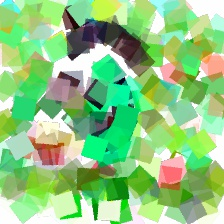

render loss: 136.625
iteration: 840

Top predictions:

         cupcake: 24.51%
             cow: 5.30%
          donkey: 4.19%
           llama: 3.64%
            cake: 2.21%
       milkshake: 2.14%
          celery: 1.75%
         dessert: 1.64%
        scallion: 1.34%
           sheep: 1.32%


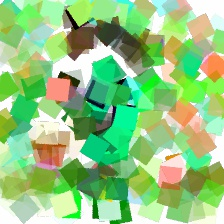

render loss: 137.0
iteration: 850

Top predictions:

          donkey: 6.06%
           horse: 5.35%
           bongo: 3.51%
         cupcake: 3.51%
             cow: 2.30%
       breakfast: 2.27%
            food: 2.10%
          yogurt: 1.85%
       milkshake: 1.82%
            cake: 1.71%


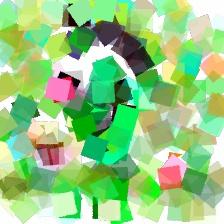

render loss: 137.125
iteration: 860

Top predictions:

         cupcake: 74.66%
           horse: 2.64%
            cake: 1.12%
       milkshake: 1.12%
          sweets: 0.94%
         dessert: 0.77%
          celery: 0.62%
           apple: 0.60%
           salad: 0.57%
        birthday: 0.54%


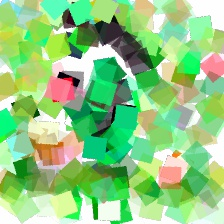

render loss: 136.875
iteration: 870

Top predictions:

         cupcake: 73.29%
            cake: 2.43%
       milkshake: 2.25%
           horse: 1.15%
           cocoa: 0.71%
          sweets: 0.60%
          donkey: 0.59%
           shake: 0.56%
        birthday: 0.55%
         dessert: 0.53%


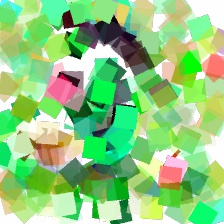

render loss: 136.875
iteration: 880

Top predictions:

         cupcake: 27.61%
           horse: 5.70%
       milkshake: 3.45%
            cake: 3.20%
        birthday: 2.57%
           spike: 1.53%
         drizzle: 1.51%
          sweets: 1.40%
         dessert: 1.33%
           shake: 1.33%


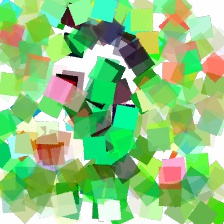

render loss: 137.0
iteration: 890

Top predictions:

         cupcake: 53.17%
            cake: 8.96%
        birthday: 6.87%
           horse: 5.61%
         dessert: 1.29%
       milkshake: 1.23%
           spike: 0.63%
          sweets: 0.62%
          donkey: 0.61%
             pet: 0.47%


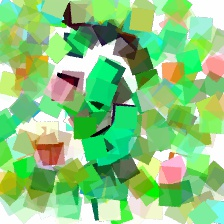

render loss: 137.375
iteration: 900

Top predictions:

            corn: 3.33%
             pea: 2.29%
           salad: 2.09%
          celery: 1.55%
           grass: 1.53%
         lettuce: 1.46%
         ravioli: 1.41%
          sprout: 1.39%
           green: 1.37%
        cucumber: 1.29%


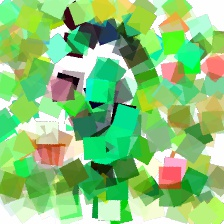

render loss: 136.625
iteration: 910

Top predictions:

         cupcake: 39.55%
       milkshake: 7.55%
           horse: 4.80%
         dessert: 3.05%
          yogurt: 2.38%
            cake: 2.16%
         custard: 1.27%
          sweets: 1.18%
           salad: 1.10%
           green: 1.05%


KeyboardInterrupt: ignored

In [ ]:
#@title Curve Optimizer {vertical-output: true}

%cd /content/diffvg/apps/

prompt = "A horse eating a green cupcake"
neg_prompt = "A messy drawing"
neg_prompt_2 = "Many small messy drawings"
text_input = clip.tokenize(prompt).to(device)
text_input_neg1 = clip.tokenize(neg_prompt).to(device)
text_input_neg2 = clip.tokenize(neg_prompt_2).to(device)
use_negative = True # Use negative prompts?

# Thanks to Katherine Crowson for this. 
# In the CLIPDraw code used to generate examples, we don't normalize images
# before passing into CLIP, but really you should. Turn this to True to do that.
use_normalized_clip = True 

# Calculate features
with torch.no_grad():
    text_features = model.encode_text(text_input)
    text_features_neg1 = model.encode_text(text_input_neg1)
    text_features_neg2 = model.encode_text(text_input_neg2)
import pydiffvg
import torch
import skimage
import skimage.io
import random
import ttools.modules
import argparse
import math
import torchvision
import torchvision.transforms as transforms

pydiffvg.set_print_timing(False)

gamma = 1.0

# ARGUMENTS. Feel free to play around with these, especially num_paths.
args = lambda: None
args.num_polygons = 300
args.num_iter = 1000
#args.max_width = 50

# Use GPU if available
pydiffvg.set_use_gpu(torch.cuda.is_available())
device = torch.device('cuda')
pydiffvg.set_device(device)

canvas_width, canvas_height = 224, 224
num_paths = args.num_polygons
#max_width = args.max_width

# Image Augmentation Transformation
augment_trans = transforms.Compose([
    #transforms.RandomPerspective(fill=1, p=1, distortion_scale=0.5),
    transforms.RandomResizedCrop(canvas_width, scale=(0.7,0.9)),
])

if use_normalized_clip:
    augment_trans = transforms.Compose([
    transforms.RandomPerspective(fill=1, p=1, distortion_scale=0.5),
    transforms.RandomResizedCrop(canvas_width, scale=(0.7,0.9)),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])


# Initialize Random Curves
shapes = []
shape_groups = []
points_to_optimize = []
angles_to_optimize = []
color_vars = []
filling = set()
max_filling_size = math.floor(num_paths/3)
for i in range(num_paths):
  if len(filling) < max_filling_size:
    filling.add(i)
  center = torch.tensor([(random.random(), random.random())])
  center.requires_grad = True

  angle = torch.tensor([random.random() * math.pi/2])
  angle.requires_grad = True

  fill_color = torch.tensor([random.random(), random.random(), random.random(), random.random()])
  fill_color.requires_grad = True

  points_to_optimize.append(center)
  angles_to_optimize.append(angle)
  color_vars.append(fill_color)

  shapes.append(create_polygon_from_center_and_orientation(center, angle, canvas_width))
  polygon_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),  fill_color = fill_color)
  shape_groups.append(polygon_group)
  
"""for i in range(num_paths):
    points = []
    p1 = (random.random(), random.random())
    points.append(p1)
    p2 = (p1[0] + random.random(), p1[1] + random.random())
    points.append(p2)
    p3 = (p2[0] + random.random(), p2[1] + random.random())
    points.append(p3)
    p4 = (p3[0] - random.random(), p3[1] - random.random())
    points.append(p4)
    print(points)
    points = torch.tensor(points)
    points.requires_grad = True
    #points = torch.rand((4,2), requires_grad = True)
    polygon = pydiffvg.Polygon(points = points, is_closed = True)
    polygon.points = points  * canvas_width
    
    points_to_optimize.append(points)
    shapes.append(polygon)
    polygon_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),  fill_color = torch.tensor([random.random(), random.random(), random.random(), random.random()]))
    shape_groups.append(polygon_group)"""

# Just some diffvg setup
scene_args = pydiffvg.RenderFunction.serialize_scene(\
    canvas_width, canvas_height, shapes, shape_groups)
render = pydiffvg.RenderFunction.apply
img = render(canvas_width, canvas_height, 2, 2, 0, None, *scene_args)

"""
points_vars = []
#stroke_width_vars = []
color_vars = []
#for polygon in shapes:

for group in shape_groups:
    group.fill_color.requires_grad = True
    color_vars.append(group.fill_color)
"""

# Optimizers
points_optim = torch.optim.Adam(points_to_optimize, lr=.01)
#width_optim = torch.optim.Adam(stroke_width_vars, lr=0.1)
color_optim = torch.optim.Adam(color_vars, lr=0.1)
angle_optim = torch.optim.Adam(angles_to_optimize, lr = 0.1)
losses = []
# Run the main optimization loop
for t in range(1,args.num_iter+1):
    """print("The angle: ", angles_to_optimize)
    print("The color: ", color_vars)
    print("The points: ",points_to_optimize)
    print("===============================")
    print("===============================")
    print("===============================")"""
    # Anneal learning rate (makes videos look cleaner)
    #if t == int(args.num_iter * 0.5):
    #    for g in points_optim.param_groups:
    #        g['lr'] = 0.4
    #if t == int(args.num_iter * 0.75):
    #    for g in points_optim.param_groups:
    #        g['lr'] = 0.1
    
    points_optim.zero_grad()
    #width_optim.zero_grad()
    color_optim.zero_grad()
    angle_optim.zero_grad()
    shapes = []
    shape_groups = []
    for i in range(len(points_to_optimize)):
      shapes.append(create_polygon_from_center_and_orientation(points_to_optimize[i], angles_to_optimize[i], canvas_width))
      shape_groups.append(pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),  fill_color = color_vars[i]))
    """
    for i in range(len(shapes)):
      shapes[i].points = points_to_optimize[i] * canvas_width
      """
    scene_args = pydiffvg.RenderFunction.serialize_scene(\
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, canvas_height, 2, 2, t, None, *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
    if t % 5 == 0:
        pydiffvg.imwrite(img.cpu(), '/content/res/iter_{}.png'.format(int(t/5)), gamma=gamma)
    img = img[:, :, :3]
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2) # NHWC -> NCHW

    loss = 0
    NUM_AUGS = 4
    img_augs = []
    for n in range(NUM_AUGS):
        img_augs.append(augment_trans(img))
    im_batch = torch.cat(img_augs)
    image_features = model.encode_image(im_batch)
    for n in range(NUM_AUGS):
        loss -= 10 *torch.cosine_similarity(text_features, image_features[n:n+1], dim=1)
        if use_negative:
            loss += torch.cosine_similarity(text_features_neg1, image_features[n:n+1], dim=1) * 0.3
            loss += torch.cosine_similarity(text_features_neg2, image_features[n:n+1], dim=1) * 0.3

    
    parallelogram_penalty = 0 #to force it to be a parallelogram
    area_penalty = 0 #try to make it a square
    grid_penalty = 0 #try to keep it in the grid
    #diamond_penalty = 0
    """
    for points in points_to_optimize:
      p1 = points[0]
      p2 = points[1]
      p3 = points[2]
      p4 = points[3]
      parallelogram_penalty += (0.5 * (torch.abs(vectors_angle_cos(p2 - p1, p3 - p4) - 1)**2 + torch.abs(vectors_angle_cos(p2 - p3, p1 - p4) - 1)**2))
      v = torch.tensor([0.5,0.5])
      grid_penalty += sum([torch.norm(p -v)**2 for p in points])
      area_penalty += 0.5 * torch.abs((torch.norm(p2-p1)**2 + torch.norm(p3-p4)**2) - (torch.norm(p2-p3)**2 + torch.norm(p4-p1)**2))
      #diamond_penalty += (0.5 * torch.abs(torch.dot(p1 - p3, p2 - p4))**2 )
    parallelogram_penalty /= len(points_to_optimize)
    area_penalty /= len(points_to_optimize)
    grid_penalty /= len(points_to_optimize)
    #diamond_penalty /= len(points_to_optimize)
    
    loss += (100* parallelogram_penalty)
    loss += (5*grid_penalty )
    loss += (10*area_penalty)
    #loss += diamond_penalty"""

    grid_penalty = 0
    distance_penalty = 0
    v = torch.tensor([0.5,0.5])
    for i, center in enumerate(points_to_optimize):
      #if i in filling:
      #  grid_penalty += 10* torch.norm(center-v)**2
      #else:
      grid_penalty += 0.5* torch.norm(center-v)**2
      tensor_copy = torch.stack(points_to_optimize[:i] + points_to_optimize[i+1:])
      distance_penalty += 0.5 * torch.abs((torch.norm(center - tensor_copy, dim = 2) - 1/2)).sum()
      #distance_penalty += 0.5 * torch.abs(torch.norm(center1 - center2) - 1/2)

    distance_penalty /= len(points_to_optimize)
    grid_penalty /= len(points_to_optimize)
    loss += 5*distance_penalty
    loss += 5*grid_penalty

    losses.append(loss.item())
    # Backpropagate the gradients.
    loss.backward()
    #losses.append(loss.item())

    # Take a gradient descent step.
    #points_optim.step()
    angle_optim.step()
    color_optim.step()
    #for path in shapes:
    #    path.stroke_width.data.clamp_(1.0, max_width)
    #for points in points_to_optimize:
    #    points.data.clamp_(0.0,1.0)
    for group in shape_groups:
        group.fill_color.data.clamp_(0.0, 1.0)
    
    if t % 10 == 0:
        show_img(img.detach().cpu().numpy()[0])
        # show_img(torch.cat([img.detach(), img_aug.detach()], axis=3).cpu().numpy()[0])
        #print(angles_to_optimize[0].grad)
        print('render loss:', loss.item())
        print('iteration:', t)
        with torch.no_grad():
            im_norm = image_features / image_features.norm(dim=-1, keepdim=True)
            noun_norm = nouns_features / nouns_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * im_norm @ noun_norm.T).softmax(dim=-1)
            values, indices = similarity[0].topk(10)
            print("\nTop predictions:\n")
            for value, index in zip(values, indices):
                print(f"{nouns[index]:>16s}: {100 * value.item():.2f}%")

In [ ]:
#@title Video Renderer {vertical-output: true}

# Render a picture with each stroke.
with torch.no_grad():
    for i in range(args.num_polygons):
        print(i)
        scene_args = pydiffvg.RenderFunction.serialize_scene(\
            canvas_width, canvas_height, shapes[:i+1], shape_groups[:i+1])
        img = render(canvas_width, canvas_height, 2, 2, t, None, *scene_args)
        img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
        pydiffvg.imwrite(img.cpu(), '/content/res/stroke_{}.png'.format(i), gamma=gamma)
print("ffmpeging")

# Convert the intermediate renderings to a video.
from subprocess import call
call(["ffmpeg", "-y", "-framerate", "60", "-i",
    "/content/res/iter_%d.png", "-vb", "20M",
    "/content/res/out.mp4"])

call(["ffmpeg", "-y", "-framerate", "60", "-i",
    "/content/res/stroke_%d.png", "-vb", "20M",
    "/content/res/out_strokes.mp4"])

call(["ffmpeg", "-y", "-i", "/content/res/out.mp4", "-filter_complex",
    "[0]trim=0:2[hold];[0][hold]concat[extended];[extended][0]overlay",
    "/content/res/out_longer.mp4"])

call(["ffmpeg", "-y", "-i", "/content/res/out_strokes.mp4", "-filter_complex",
    "[0]trim=0:2[hold];[0][hold]concat[extended];[extended][0]overlay",
    "/content/res/out_strokes_longer.mp4"])


display(mvp.ipython_display("/content/res/out_longer.mp4"))
display(mvp.ipython_display("/content/res/out_strokes_longer.mp4"))

  skimage.io.imsave(filename, (img * 255).astype(np.uint8))



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
#@title Pixel Optimizer (Ignore) {vertical-output: true}

%cd /content/diffvg/apps/

prompt = "Underwater"
text_input = clip.tokenize(prompt).to(device)

# Calculate features
with torch.no_grad():
    text_features = model.encode_text(text_input)

import torch
import skimage
import skimage.io
import random
import ttools.modules
import argparse
import math
import torchvision
import torchvision.transforms as transforms



class ImageBase(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.p = torch.nn.Parameter(torch.ones(224, 224, 3))
    def forward(self):
        return torch.nn.functional.sigmoid(self.p)

device = torch.device('cuda')
canvas_width, canvas_height = 224, 224

augment_trans = transforms.Compose([
    transforms.RandomPerspective(fill=1, p=1),
    transforms.RandomResizedCrop(224, scale=(0.7,0.9)),
])

ib = ImageBase().to(device)

t_img = imread('https://lh5.googleusercontent.com/mjvIYutjtOGEEU2cBYuFMvCrBCg4-MGh3DqCRlLqwn5I6VvdKdtwWvAYlndQbv-VUudPcecQ_TEGFjYaTuS_r0LNI83Sp8MlXJb6OarJ9mu-IkmKPlg9Gaw3gOjQvvgvuUB5ghJjlaE')
target = torch.from_numpy(t_img).to(torch.float32)
ib.p = target

# Optimize
optim = torch.optim.Adam(ib.parameters(), lr=0.01)
# Adam iterations.
for t in range(args.num_iter):
    optim.zero_grad()
    img = ib()
    # Convert img from HWC to NCHW
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2) # NHWC -> NCHW

    loss = 0
    for n in range(16):
        img_aug = augment_trans(img)
        image_features = model.encode_image(img_aug)
        loss -= torch.cosine_similarity(text_features, image_features, dim=1)
        # loss += torch.abs(torch.mean(1-img_aug)) * 0.1

    # Backpropagate the gradients.
    loss.backward()

    # Take a gradient descent step.
    optim.step()
    
    if t % 10 == 0:
        show_img(img.detach().cpu().numpy()[0])
        show_img(img_aug.detach().cpu().numpy()[0])
        print('render loss:', loss.item())
        print('iteration:', t)
        with torch.no_grad():
            im_norm = image_features / image_features.norm(dim=-1, keepdim=True)
            noun_norm = nouns_features / nouns_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * im_norm @ noun_norm.T).softmax(dim=-1)
            values, indices = similarity[0].topk(5)
            print("\nTop predictions:\n")
            for value, index in zip(values, indices):
                print(f"{nouns[index]:>16s}: {100 * value.item():.2f}%")

# Convert the intermediate renderings to a video.
from subprocess import call
call(["ffmpeg", "-framerate", "24", "-i",
    "results/painterly_rendering/iter_%d.png", "-vb", "20M",
    "results/painterly_rendering/out.mp4"])